# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from wordcloud import WordCloud
from src.code import (
    load_datasets
)

# Load LiarPlus Dataset

In [ ]:
train_path = "../data/train2.tsv"
val_path = "../data/val2.tsv"
test_path = "../data/test2.tsv"
df_train, df_val, df_test = load_datasets(
    train_path, val_path, test_path
) #preprocessing was done in load_datasets


In [19]:
df_train.head()

,id,label,statement,subject,speaker,job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
0,2635,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [20]:
df_train.shape

(10240, 15)

# EDA

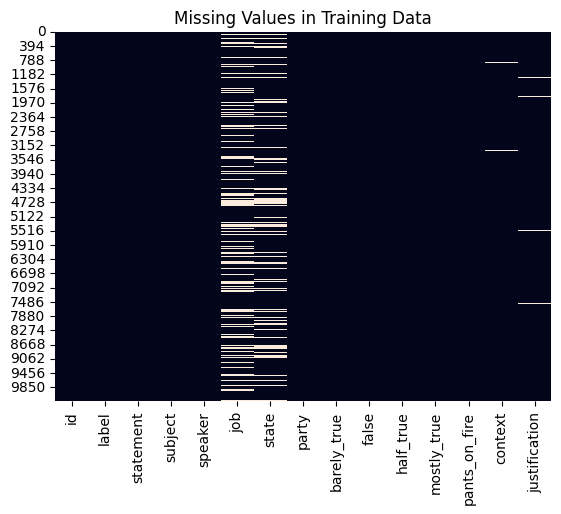

In [21]:
sns.heatmap(df_train.isna(), cbar=False)
plt.title("Missing Values in Training Data")
plt.show()

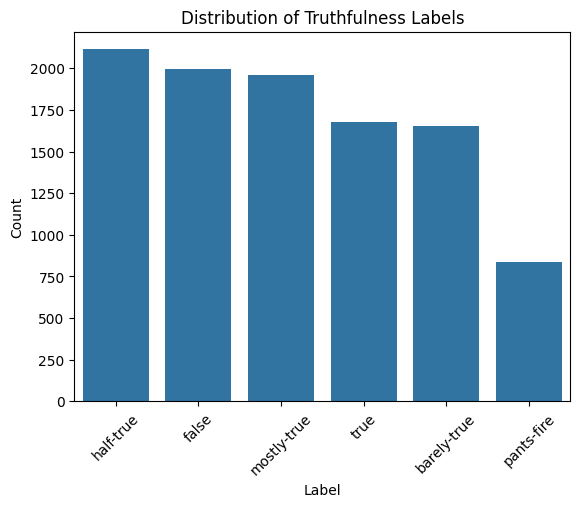

In [22]:
sns.countplot(data=df_train, x="label", order=df_train["label"].value_counts().index)
plt.title("Distribution of Truthfulness Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Echo Chamber

/var/folders/lj/5gvcfpcj0sz1q841pw7jmk5m0000gn/T/ipykernel_14389/654207525.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="coolwarm")


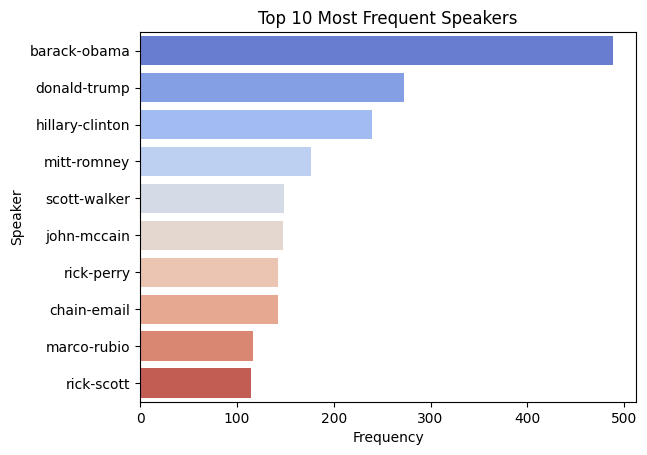

In [23]:
top_speakers = df_train["speaker"].value_counts().nlargest(10)
sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="coolwarm")
plt.title("Top 10 Most Frequent Speakers")
plt.xlabel("Frequency")
plt.ylabel("Speaker")
plt.show()

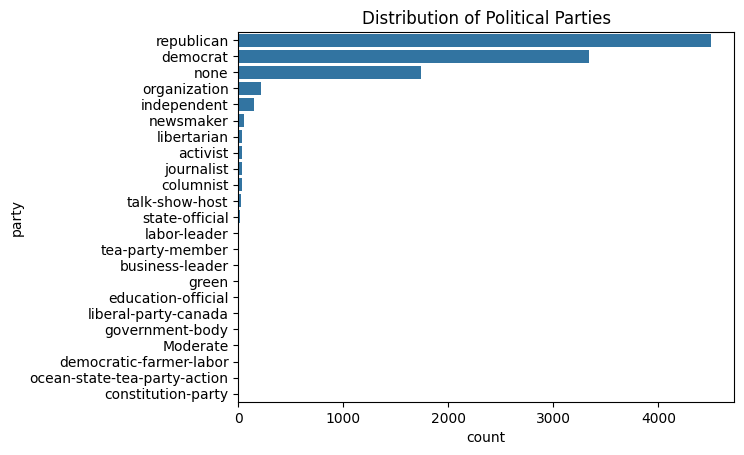

In [24]:
sns.countplot(data=df_train, y="party", order=df_train["party"].value_counts().index)
plt.title("Distribution of Political Parties")
plt.show()

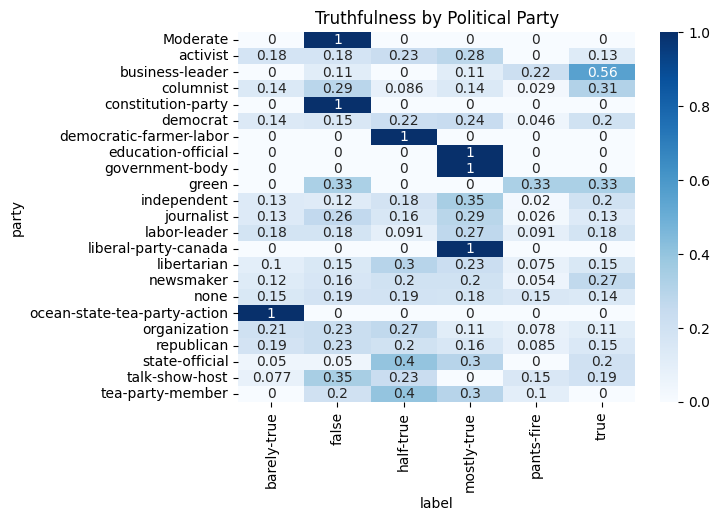

In [25]:
sns.heatmap(pd.crosstab(df_train["party"], df_train["label"], normalize="index"), annot=True, cmap="Blues")
plt.title("Truthfulness by Political Party")
plt.show()

## Frequency Heuristic

In [26]:
subject_counts = Counter(chain.from_iterable(df_train['subject'].dropna().str.split(',')))
subject_df = pd.DataFrame(subject_counts.most_common(15), columns=['Subject', 'Count'])

/var/folders/lj/5gvcfpcj0sz1q841pw7jmk5m0000gn/T/ipykernel_14389/1422551564.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subject_df, x='Count', y='Subject', palette='mako')


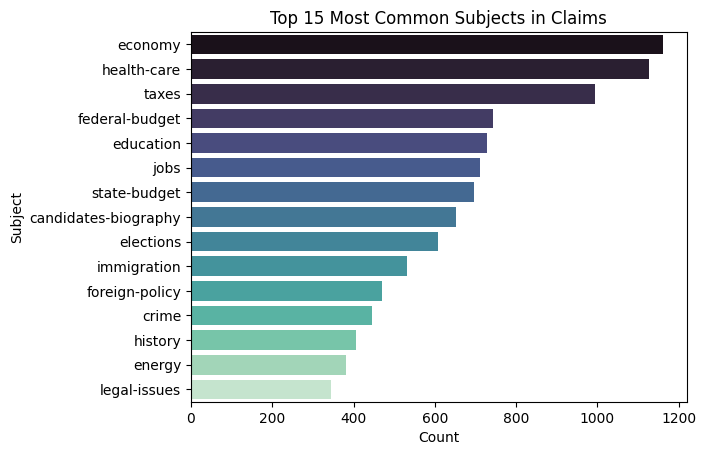

In [27]:
sns.barplot(data=subject_df, x='Count', y='Subject', palette='mako')
plt.title("Top 15 Most Common Subjects in Claims")
plt.show()

## Sensationalism

In [28]:
df_train['statement_length'] = df_train['statement'].apply(lambda x: len(str(x).split()))

/var/folders/lj/5gvcfpcj0sz1q841pw7jmk5m0000gn/T/ipykernel_14389/668320695.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='label', y='statement_length', palette='Set2')


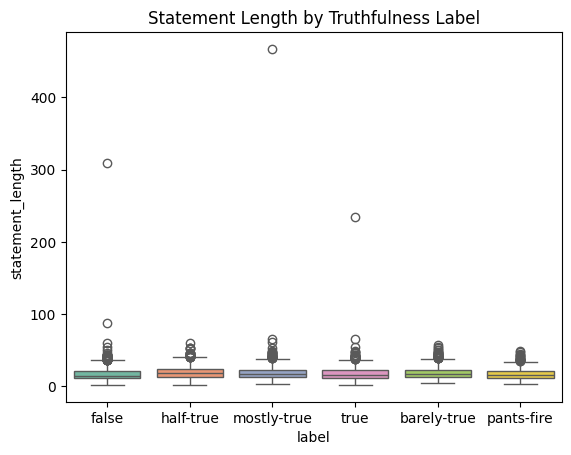

In [29]:
sns.boxplot(data=df_train, x='label', y='statement_length', palette='Set2')
plt.title("Statement Length by Truthfulness Label")
plt.show()

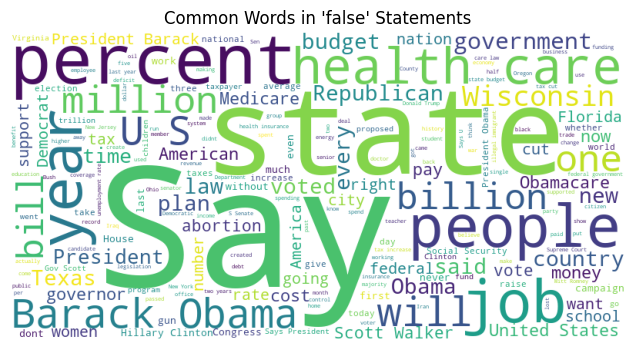

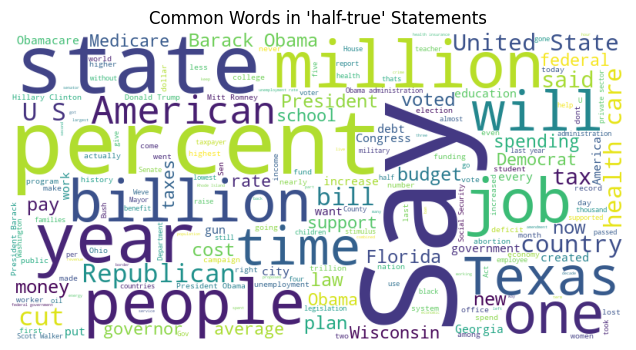

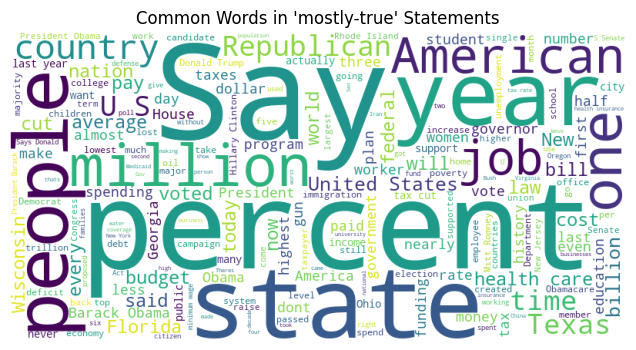

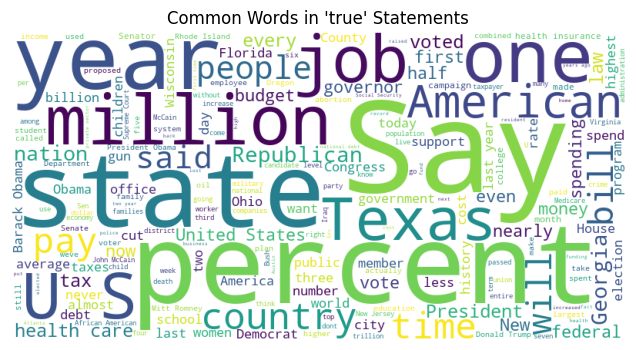

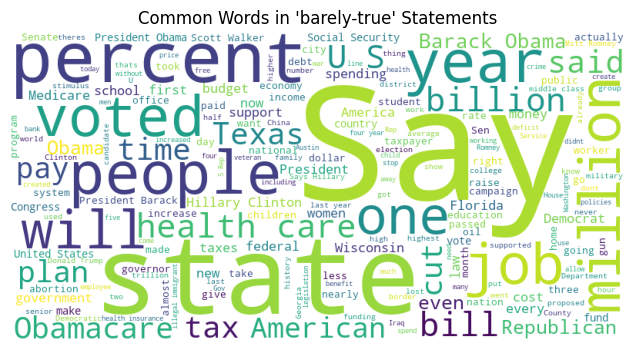

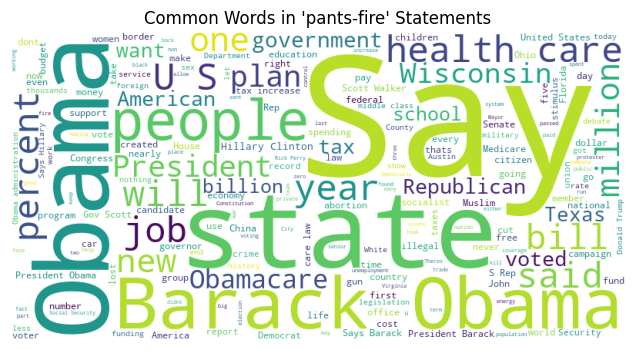

In [30]:
for label in df_train['label'].unique():
    text = " ".join(df_train[df_train['label']==label]['statement'].astype(str))
    plt.figure(figsize=(8,4))
    plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(text))
    plt.axis('off')
    plt.title(f"Common Words in '{label}' Statements")
    plt.show()

## Credibility

In [31]:
speaker_scores = df_train.groupby("speaker")[["barely_true", "false", "half_true", "mostly_true", "pants_on_fire"]].sum()
speaker_scores["credibility_score"] = (
    (speaker_scores["mostly_true"] + speaker_scores["half_true"]) -
    (speaker_scores["false"] + speaker_scores["pants_on_fire"])
)

In [32]:
top_cred = speaker_scores["credibility_score"].nlargest(10)
low_cred = speaker_scores["credibility_score"].nsmallest(10)

/var/folders/lj/5gvcfpcj0sz1q841pw7jmk5m0000gn/T/ipykernel_14389/1557855951.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cred.values, y=top_cred.index, palette="Greens_r")


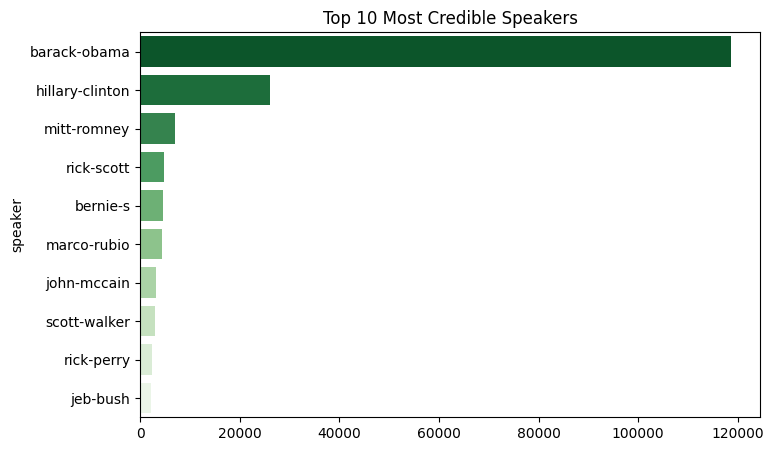

In [33]:
plt.figure(figsize=(8,5))
sns.barplot(x=top_cred.values, y=top_cred.index, palette="Greens_r")
plt.title("Top 10 Most Credible Speakers")
plt.show()

/var/folders/lj/5gvcfpcj0sz1q841pw7jmk5m0000gn/T/ipykernel_14389/691468705.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=low_cred.values, y=low_cred.index, palette="Reds_r")


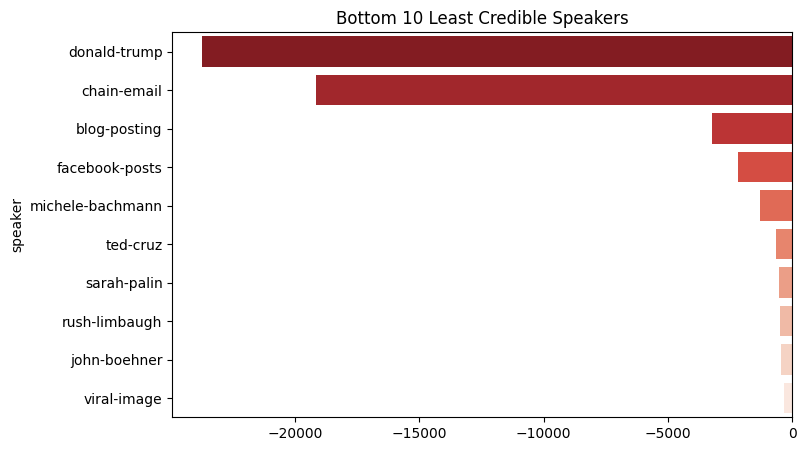

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(x=low_cred.values, y=low_cred.index, palette="Reds_r")
plt.title("Bottom 10 Least Credible Speakers")
plt.show()

## Cross-Factor Validation

/var/folders/lj/5gvcfpcj0sz1q841pw7jmk5m0000gn/T/ipykernel_14389/1425902632.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=context_counts.values, y=context_counts.index, palette="viridis")


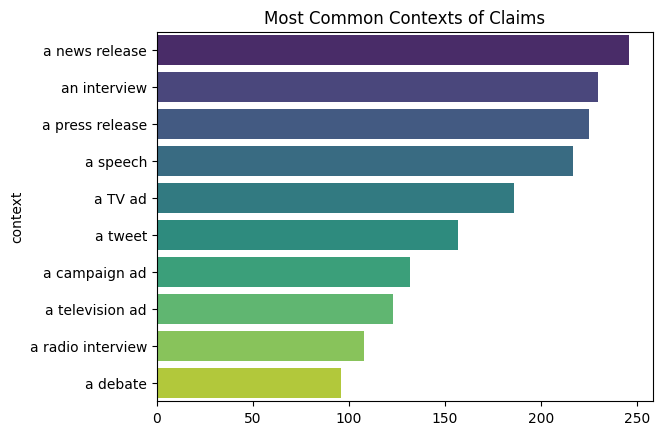

In [35]:
context_counts = df_train["context"].value_counts().nlargest(10)
sns.barplot(x=context_counts.values, y=context_counts.index, palette="viridis")
plt.title("Most Common Contexts of Claims")
plt.show()

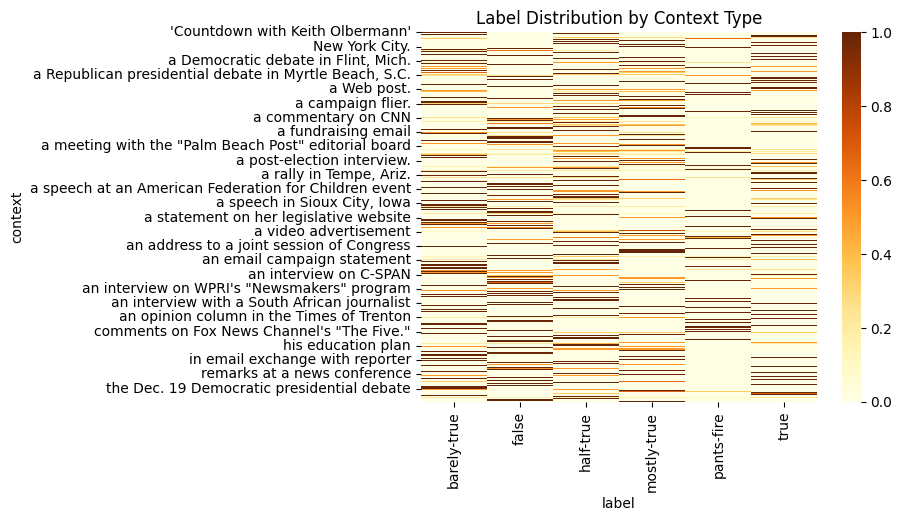

In [36]:
sns.heatmap(pd.crosstab(df_train["context"], df_train["label"], normalize="index"), cmap="YlOrBr")
plt.title("Label Distribution by Context Type")
plt.show()